XGBOOST: Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Fold 1
  RMSE: 0.1483 | R²: 0.6970 | MAE: 0.1039
Fold 2
  RMSE: 0.1634 | R²: 0.6492 | MAE: 0.1169
Fold 3
  RMSE: 0.1332 | R²: 0.7545 | MAE: 0.1000
Fold 4
  RMSE: 0.1510 | R²: 0.6926 | MAE: 0.1150
Fold 5
  RMSE: 0.1530 | R²: 0.6852 | MAE: 0.1115

RMSE promedio: 0.1498 (±0.0098)
R² promedio: 0.6957 (±0.0339)
MAE promedio: 0.1095 (±0.0065)

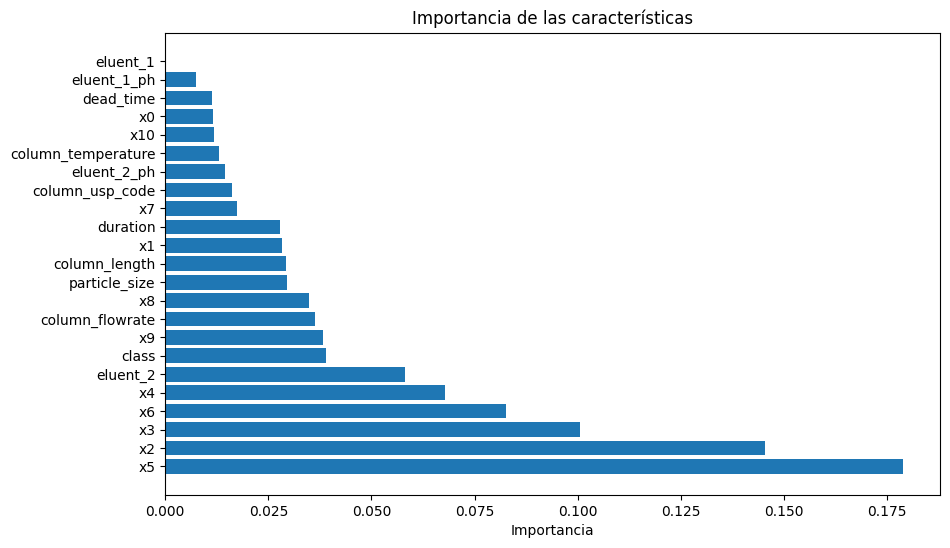

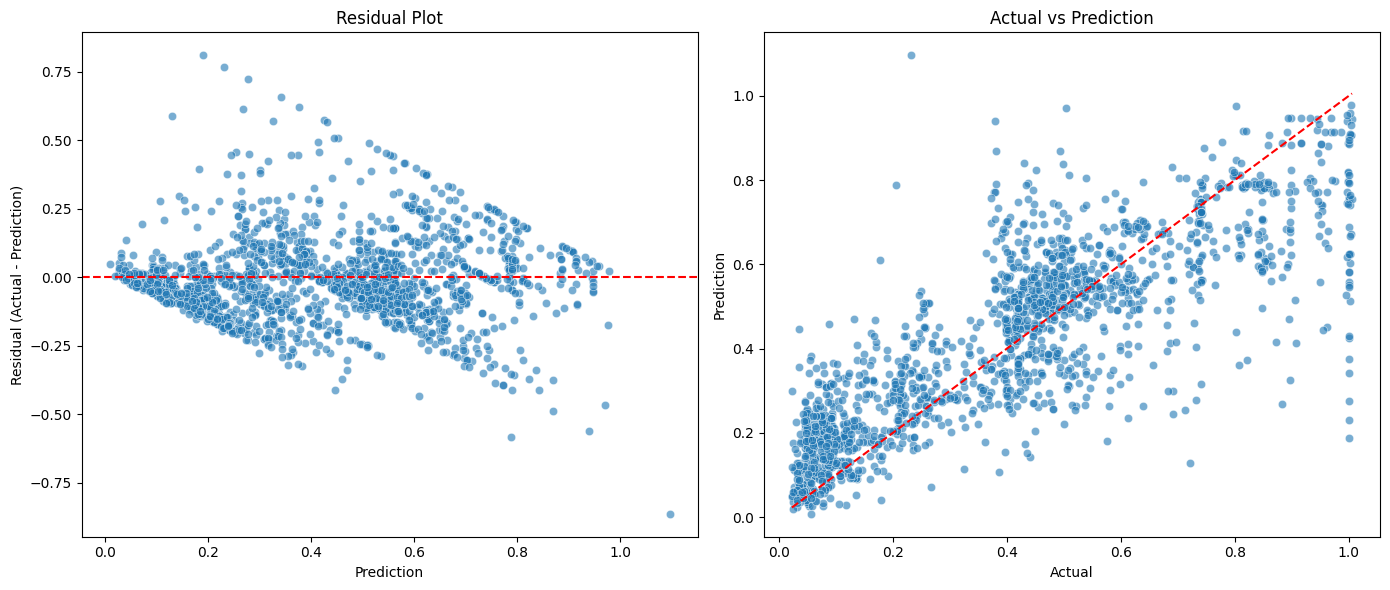

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------- 1. Renombrar columnas ----------
'''
column_map = {
    "Clase": "Class",
    "Eluyente1": "Eluent1",
    "Eluyente2": "Eluent2",
    "pH1": "pH1",
    "pH2": "pH2",
    "USP Code": "USP_Code",
    "Longitud": "Length",
    "Tamaño de Partícula": "Particle_Size",
    "Temperatura": "Temperature",
    "Flujo": "Flow",
    "T0": "T0",
    "Score": "Score",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "Intercepto": "Intercept",
    "duration": "Duration"
}'''
column_map = {
    "Clase": "class",
    "Eluyente1": "eluent_1",
    "Eluyente2": "eluent_2",
    "pH1": "eluent_1_ph",
    "pH2": "eluent_2_ph",
    "USP Code": "column_usp_code",
    "Longitud": "column_length",
    "Tamaño de Partícula": "particle_size",
    "Temperatura": "column_temperature",
    "Flujo": "column_flowrate",
    "T0": "dead_time",
    "Score": "score",
    "Intercepto": "x0",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "duration": "duration"
}

df_smogn.rename(columns=column_map, inplace=True)

# ---------- 2. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["score"].values
    X = df.drop(columns=["score"]).copy()

    #cat_cols = ["Class", "Eluent1", "Eluent2", "USP_Code"]
    cat_cols = ["class", "eluent_1", "eluent_2", "column_usp_code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 3. Preprocesamiento ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)
y_transformed = y ** 0.25
sample_weights = 1 + 4 * y

# ---------- 4. Estratificación y Validación cruzada ----------
# Crear etiquetas estratificadas a partir de y
n_bins = 10
y_strat = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')  # Etiquetas para estratificación

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []
all_y_test = []
all_y_pred = []

# Ajustar el rango de hiperparámetros para evitar una búsqueda de cuadrícula amplia
param_grid = {
    'n_estimators': [100, 150, 200],  # Reducir la cantidad de estimadores
    'learning_rate': [0.05, 0.1],  # Rango más pequeño para la tasa de aprendizaje
    'max_depth': [3, 5],  # Reducir la profundidad máxima
    'subsample': [0.8, 1.0],  # Rango de subsample
    'colsample_bytree': [0.8, 1.0],  # Similar a subsample
}

# Crear el objeto XGBRegressor para GridSearchCV
model = XGBRegressor(
    objective='reg:squarederror',
    verbosity=0,
    random_state=42
)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_processed, y_transformed)

# Mostrar el mejor conjunto de hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Usar el mejor modelo del grid search
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
for fold, (train_index, test_index) in enumerate(skf.split(X_processed, y_strat)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    best_model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    y_pred = best_model.predict(X_test_imputed)
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de la Importancia de Características ----------
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.barh(range(X_processed.shape[1]), importances[indices], align="center")
plt.yticks(range(X_processed.shape[1]), X_processed.columns[indices])
plt.xlabel("Importancia")
plt.show()

# ---------- 6. Visualización de Residuales y Predicciones ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prediction")
plt.ylabel("Residual (Actual - Prediction)")
plt.title("Residual Plot")

plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")

plt.tight_layout()
plt.show()

# ---------- 7. Entrenamiento final y guardado ----------
imputer = SimpleImputer(strategy='mean')
X_all_imputed = imputer.fit_transform(X_processed)
y_all_transformed = y ** 0.25
weights_all = 1 + 4 * y

best_model.fit(X_all_imputed, y_all_transformed, sample_weight=weights_all)

joblib.dump({
    'model': best_model,
    'imputer': imputer,
    'encoder': encoder,
    'column_order': list(X_processed.columns)
}, "modelo_xgboost.pkl")

print("✅ Modelo final guardado como modelo_xgboost_ajustado.pkl")


RANDOM FOREST: 

Fold 1
  RMSE: 0.1331 | R²: 0.7689 | MAE: 0.0752
Fold 2
  RMSE: 0.1455 | R²: 0.7042 | MAE: 0.0841
Fold 3
  RMSE: 0.1440 | R²: 0.7259 | MAE: 0.0838
Fold 4
  RMSE: 0.1358 | R²: 0.7427 | MAE: 0.0785
Fold 5
  RMSE: 0.1299 | R²: 0.7693 | MAE: 0.0748

RMSE promedio: 0.1377 (±0.0061)
R² promedio: 0.7422 (±0.0251)
MAE promedio: 0.0793 (±0.0040)

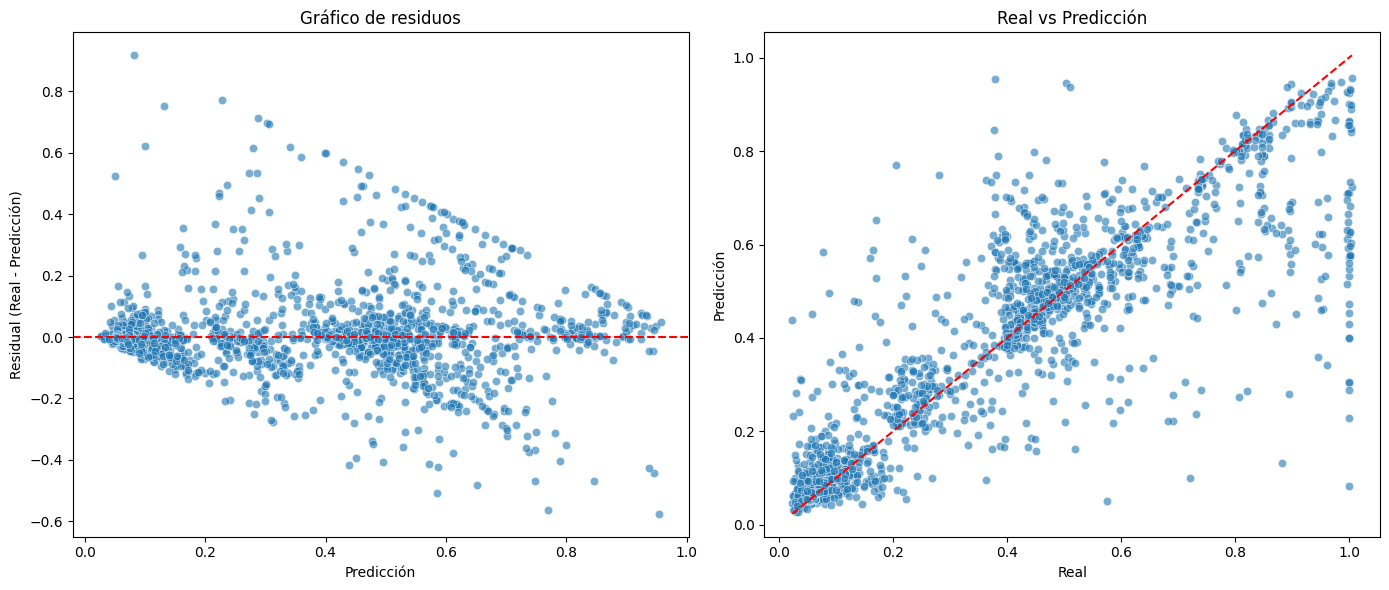

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

column_map = {
    "Clase": "class",
    "Eluyente1": "eluent_1",
    "Eluyente2": "eluent_2",
    "pH1": "eluent_1_ph",
    "pH2": "eluent_2_ph",
    "USP Code": "column_usp_code",
    "Longitud": "column_length",
    "Tamaño de Partícula": "particle_size",
    "Temperatura": "column_temperature",
    "Flujo": "column_flowrate",
    "T0": "dead_time",
    "Score": "score",
    "Intercepto": "x0",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "duration": "duration"
}

df_smogn.rename(columns=column_map, inplace=True)
# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["score"].values
    X = df.drop(columns=["score"]).copy()

    # Codificación de variables categóricas
    #cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    cat_cols = ["class", "eluent_1", "eluent_2", "column_usp_code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo Random Forest
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()


LightGBM:
Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3014
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 22
[LightGBM] [Info] Start training from score 0.698687
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
  RMSE: 0.1346 | R²: 0.7637 | MAE: 0.0835
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.699779
  RMSE: 0.1484 | R²: 0.6921 | MAE: 0.0900
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2885
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.697854
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
  RMSE: 0.1428 | R²: 0.7306 | MAE: 0.0869
Fold 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.703088
  RMSE: 0.1426 | R²: 0.7164 | MAE: 0.0851
Fold 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3172
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.705467
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
  RMSE: 0.1369 | R²: 0.7440 | MAE: 0.0824

RMSE promedio: 0.1410 (±0.0049)
R² promedio: 0.7293 (±0.0243)
MAE promedio: 0.0856 (±0.0027)

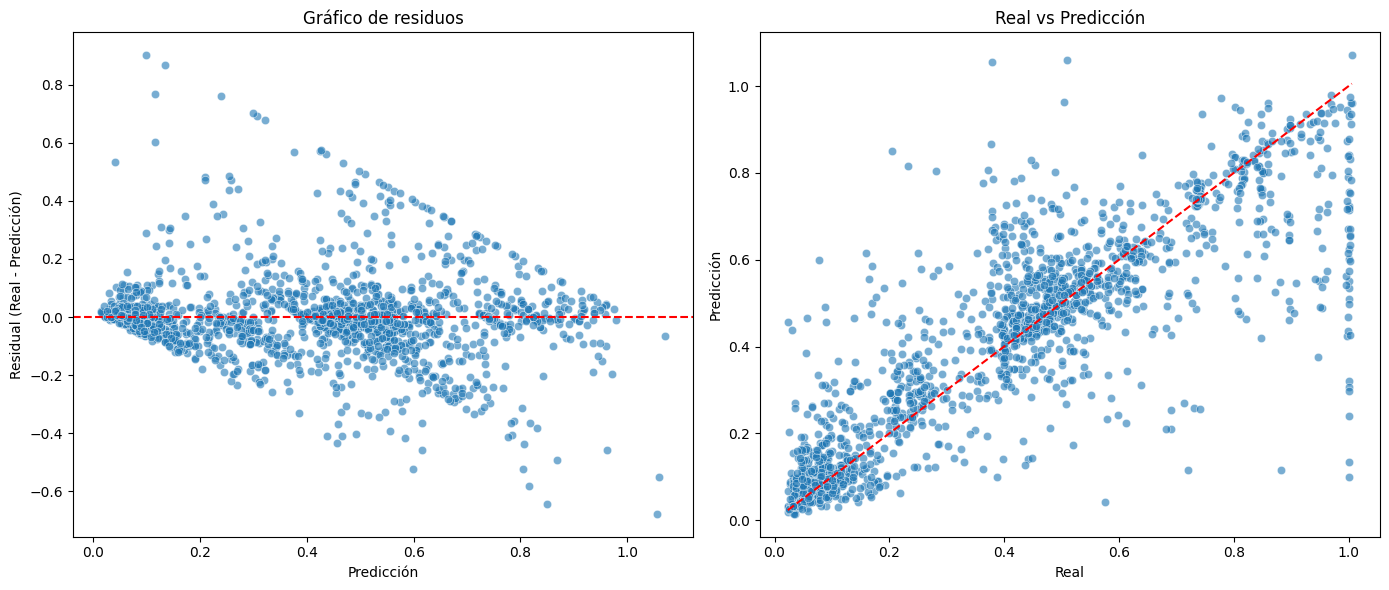

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    # Codificación de variables categóricas
    cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo LightGBM
    model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)  

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2 
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()

RRNN:
📦 Fold 1/5
⏹️ Early stopping at epoch 46
✅ Fold 1: RMSE=0.0205, MAE=0.1070, R²=0.4596

📦 Fold 2/5
✅ Fold 2: RMSE=0.0202, MAE=0.1053, R²=0.4377

📦 Fold 3/5
⏹️ Early stopping at epoch 72
✅ Fold 3: RMSE=0.0211, MAE=0.1082, R²=0.4438

📦 Fold 4/5
⏹️ Early stopping at epoch 62
✅ Fold 4: RMSE=0.0184, MAE=0.0993, R²=0.4749

📦 Fold 5/5
⏹️ Early stopping at epoch 85
✅ Fold 5: RMSE=0.0183, MAE=0.1001, R²=0.4778

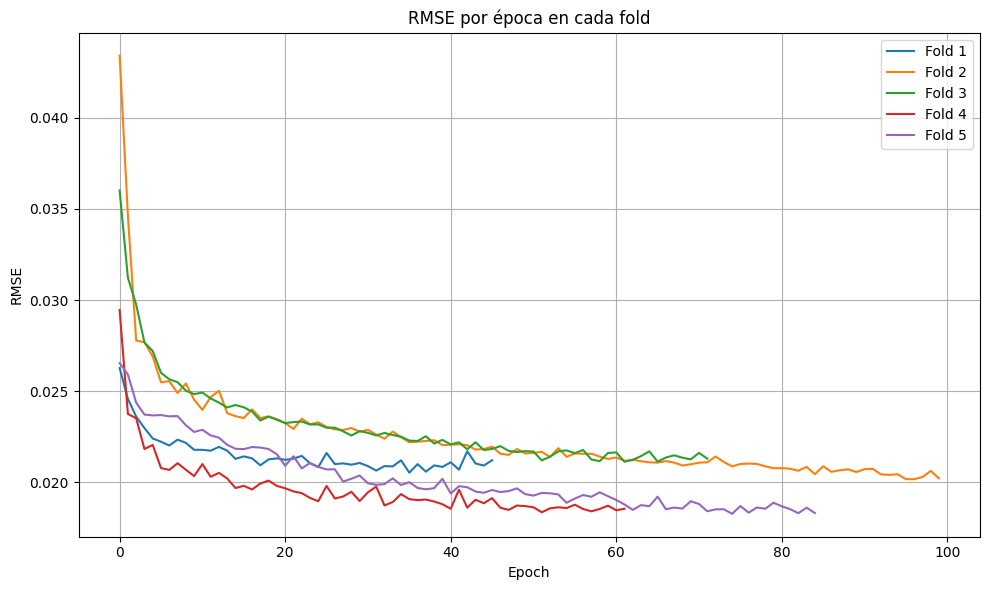

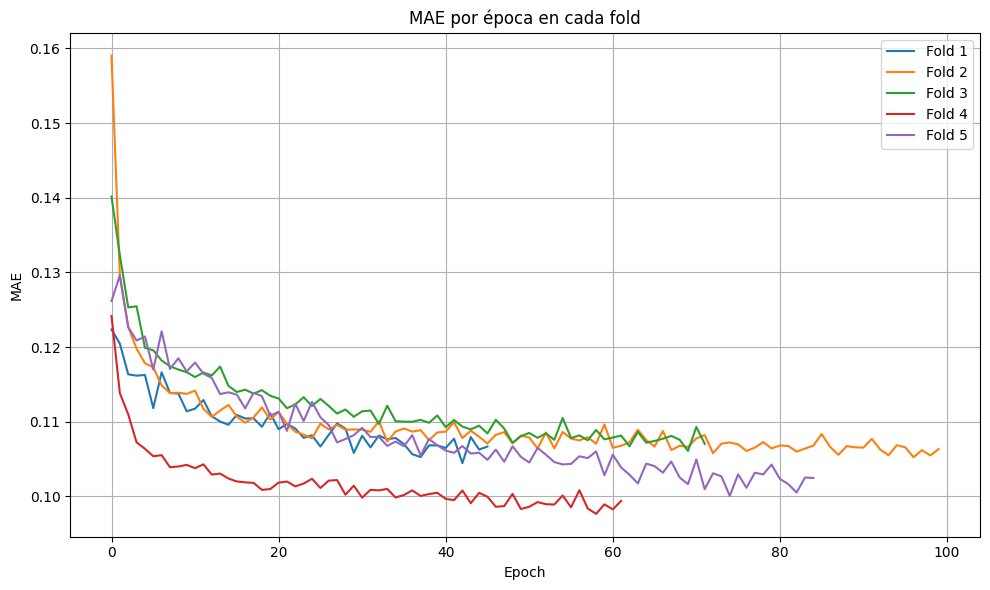

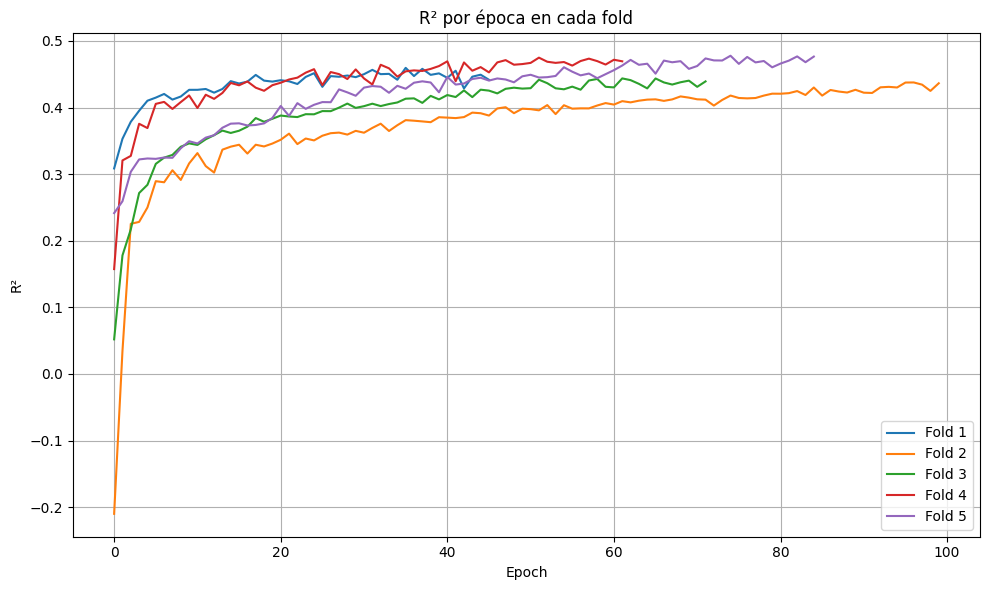

📊 Resumen por fold:
       rmse       mae        r2
0  0.020530  0.107019  0.459592
1  0.020170  0.105253  0.437677
2  0.021131  0.108154  0.443751
3  0.018356  0.099251  0.474915
4  0.018272  0.100079  0.477786

📈 Promedio ± Desviación estándar:
RMSE: 0.0197 ± 0.0013
MAE: 0.1040 ± 0.0041
R2: 0.4587 ± 0.0180

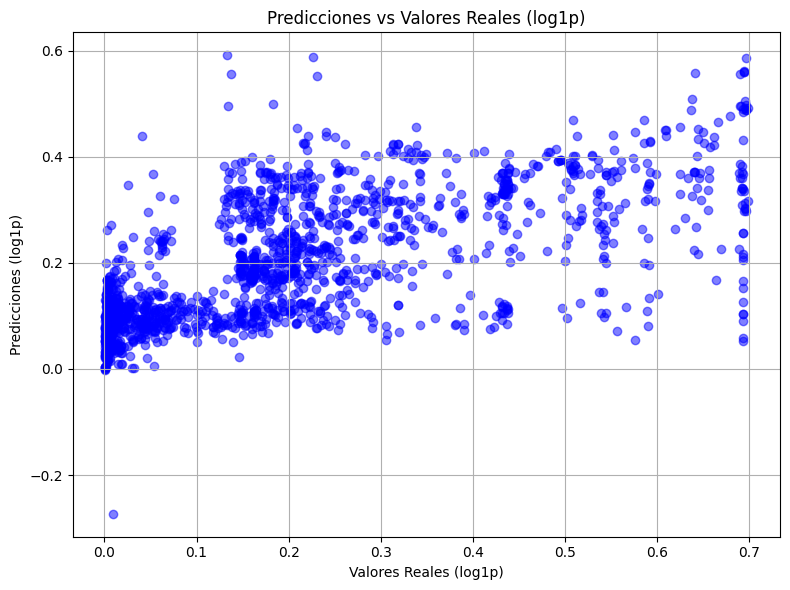

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

# ---------- 1. Preprocesamiento con Log + Pesos de Muestra ----------

def preprocess_with_log(df):
    y = df["Score"].values.astype(np.float32)
    X = df.drop(columns=["Score"]).copy()  # Eliminamos la columna "Score"

    # Transformación logarítmica del target
    y = np.log1p(y)

    # Codificación de variables categóricas
    cat_cols = ["Class", "Eluent1", "Eluent2", "USP_Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    # Imputación y escalado
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Guardar objetos
    joblib.dump(encoder, 'encoder.pkl')
    joblib.dump(imputer, 'imputer.pkl')
    joblib.dump(scaler, 'scaler.pkl')

    # Usaremos un peso de muestra mayor para valores grandes de y
    sample_weights = np.sqrt(y)  # Los valores más grandes tienen más peso

    return X_scaled.astype(np.float32), y, sample_weights, encoder, imputer, scaler

# ---------- 2. Red Neuronal ----------
class ScoreNet(nn.Module):
    def __init__(self, input_size):
        super(ScoreNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)  # Activación lineal, no Sigmoid
        )

    def forward(self, x):
        return self.model(x)

# ---------- 3. Entrenamiento y Validación ----------
def train_model_cv(X, y, sample_weights, n_splits=5, epochs=100, patience=10, batch_size=64):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    history_rmse, history_mae, history_r2 = [], [], []
    summary_metrics = []
    all_val_preds = []
    all_val_targets = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n📦 Fold {fold + 1}/{n_splits}")

        X_train, y_train, weights_train = X[train_idx], y[train_idx], sample_weights[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=batch_size)

        model = ScoreNet(input_size=X.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.MSELoss()

        best_rmse = np.inf
        best_metrics = {}
        epochs_no_improve = 0

        fold_rmse, fold_mae, fold_r2 = [], [], []

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb).squeeze()
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            # Validación
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    preds = model(xb).squeeze()
                    val_preds.extend(preds.numpy())
                    val_targets.extend(yb.numpy())

            rmse = mean_squared_error(val_targets, val_preds)
            mae = mean_absolute_error(val_targets, val_preds)
            r2 = r2_score(val_targets, val_preds)

            fold_rmse.append(rmse)
            fold_mae.append(mae)
            fold_r2.append(r2)

            if rmse < best_rmse:
                best_rmse = rmse
                best_metrics = {'rmse': rmse, 'mae': mae, 'r2': r2}
                best_model = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1}")
                    break

        history_rmse.append(fold_rmse)
        history_mae.append(fold_mae)
        history_r2.append(fold_r2)
        summary_metrics.append(best_metrics)

        all_val_preds.extend(val_preds)
        all_val_targets.extend(val_targets)

        print(f"✅ Fold {fold+1}: RMSE={best_metrics['rmse']:.4f}, MAE={best_metrics['mae']:.4f}, R²={best_metrics['r2']:.4f}")

    return best_model, history_rmse, history_mae, history_r2, summary_metrics, all_val_preds, all_val_targets

# ---------- 4. Visualización ----------
def plot_metrics(metric_histories, metric_name):
    plt.figure(figsize=(10, 6))
    for i, values in enumerate(metric_histories):
        plt.plot(values, label=f'Fold {i+1}')
    plt.title(f'{metric_name} por época en cada fold')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_summary_table(metrics):
    df = pd.DataFrame(metrics)
    print("\n📊 Resumen por fold:")
    print(df)

    print("\n📈 Promedio ± Desviación estándar:")
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        print(f"{col.upper()}: {mean:.4f} ± {std:.4f}")

# ---------- 5. Ejecución principal ----------
X_np, y_np, sample_weights, encoder, imputer, scaler = preprocess_with_log(df_2)

best_model, rmse_hist, mae_hist, r2_hist, summary, all_val_preds, all_val_targets = train_model_cv(X_np, y_np, sample_weights)

plot_metrics(rmse_hist, "RMSE")
plot_metrics(mae_hist, "MAE")
plot_metrics(r2_hist, "R²")

print_summary_table(summary)

# ---------- 6. Gráfico de dispersión ----------
plt.figure(figsize=(8, 6))
plt.scatter(all_val_targets, all_val_preds, color='blue', alpha=0.5)
plt.title("Predicciones vs Valores Reales (log1p)")
plt.xlabel("Valores Reales (log1p)")
plt.ylabel("Predicciones (log1p)")
plt.grid(True)
plt.tight_layout()
plt.show()
